# Phase Space Plotter (2D)

In [1]:
import numpy as np
from numpy import log as ln
import matplotlib.pyplot as plt
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Integrator (RK4 single step)

In [2]:
def rk4s(f,h,x):
    k1 = h*f(x)
    k2 = h*f(x+0.5*k1)
    k3 = h*f(x+0.5*k2)
    k4 = h*f(x+k3)
    x += (k1+2*k2+2*k3+k4)/6
    return x

#### Mesh Generators

**getGrid** <
__lims :__ [minX,maxX,minY,maxY] _figure limits_ |
__kx :__ (int) _number of x steps_ |
__+ky :__ (int) _number of y steps_ >

In [3]:
def getGrid(lims,kx,ky=None):
    if ky is None:ky = int(kx*np.diff(lims[2:])/np.diff(lims[:2]))
    points = []
    for x in np.linspace(lims[0],lims[1],num=kx, endpoint=True):
        for y in np.linspace(lims[2],lims[3],num=ky, endpoint=True):
            points.append((x,y))
    return points

**getHex** <
__x :__ (float) _center x coordinate_ |
__y :__ (float) _center y coordinate_ |
__R :__ (int) _radius of hexgrid_ |
__k :__ (int) _number of radial hex steps_ |
__+center :__ (bool) _include center_ >

In [4]:
def getHex(x,y,R,k,center=True):
    R = R/k
    points=[(x,y)] if center else []
    angle = [i*math.pi/3 for i in range(6)]
    dx = [ R*(math.cos(angle[(i+1)%6])-math.cos(angle[i])) for i in range(6) ]
    dy = [ R*(math.sin(angle[(i+1)%6])-math.sin(angle[i])) for i in range(6) ]
    for r in range(1,k):
        for a in range(6):
            xn = x+r*R*math.cos(angle[a])
            yn = y+r*R*math.sin(angle[a])
            points.append((xn,yn))
            for e in range(1,r):
                points.append((xn+e*dx[a],yn+e*dy[a]))
    return points

**getLine** <
__xs :__ (float) _start x coordinate_ |
__ys :__ (float) _start y coordinate_ |
__dx :__ (float) _x-span of line_ |
__dy :__ (float) _y-span of line_ >

In [5]:
def getLine(xs,ys,dx,dy,k):
    return [(xs+i*dx/k,ys+i*dy/k) for i in range(k)]

### Plot Phase Space
**PlotSpace** <
__f :__ (function) _Jacobian_ |
__lims :__ [minX,maxX,minY,maxY] _figure limits_ |
__points :__ [(x,y),..] _initial points_ |
__L :__ (int,float,int) {steps,dt,transient} _integration scheme_ |
__size :__ (int,int) {width,height} _figure size_ |
__title :__ (str) _figure name_ |
__+frame :__ (any) _unique filename_ |
__+bounded :__ (bool) _abandon trajectories outside limits_ |
__+xPeriodic :__ (bool) _dimension x is periodic_ |
__+yPeriodic :__ (bool) _dimension y is periodic_ |
__+poi :__ [(x,y),..] _points of interest_ |
__+xl :__ [x,..] _vertical lines_ |
__+yl :__ [y,..] _horizontal lines_ |
__lw :__ (float) _line width_ |
__+ms :__ _initial point marker size_ |
__+pms :__ _poi marker size_ |
__+marker :__ (char) _poi marker type_ |
__+dpi :__ (int) _dpi for saved image_ |
__+trans_alpha :__ (float) _alpha of transients_ >

In [70]:
def PlotSpace(f, lims, points, L, size, title='', frame=None, bounded=True, xPeriodic=False, yPeriodic=False,
              poi=[], xl=[], yl=[], lw=0.3, ms=2, pms=8, marker='o', dpi=60, trans_alpha=0.2):
    if frame is None: print('Max log(Load) : %.2f'%(ln(len(points)*L[0])/ln(10)))
    def draw(it): plt.plot([X1[0],X2[0]],[X1[1],X2[1]], 
            marker ='.', c='r', alpha=(1 if (it>=L[2]) else trans_alpha),ms=0, lw=lw)  
    xspan,yspan=lims[1]-lims[0],lims[3]-lims[2]
    F = np.zeros(2)
    plt.figure(figsize=size).gca().set_title(title,fontsize=16)
    plt.xlim(lims[0],lims[1]) 
    plt.ylim(lims[2],lims[3])
    for (x,y) in points:
        X1 = [x,y]
        plt.plot(x,y, marker ='o', c='k', ms=ms)
        for it in range(L[0]):
            X2 = rk4s(f,L[1],X1) 
            if xPeriodic:
                if X2[0]>lims[1]: draw(it); X2[0] -= xspan; X1[0] -= xspan
                if X2[0]<lims[0]: draw(it); X2[0] += xspan; X1[0] += xspan
            elif bounded:
                 if ((X1[0]<lims[0]) or (X1[0]>lims[1])): break  
            if yPeriodic:
                if X2[1]>lims[3]: draw(it); X2[1] -= yspan; X1[1] -= yspan
                if X2[1]<lims[2]: draw(it); X2[1] += yspan; X1[1] += yspan
            elif bounded:
                if ((X1[1]<lims[2]) or (X1[1]>lims[3])): break  
            draw(it)
            X1[:] = X2[:]
    for (x,y) in poi: plt.plot(x,y, marker=marker, c='b', ms=pms)
    for x in xl: plt.axvline(x=x,ls='--',c='k',alpha=.5)
    for y in yl: plt.axhline(y=y,ls='--',c='k',alpha=.5)   
    if frame is None: plt.show()
    else : 
        plt.savefig('frames/'+str(frame)+'.png', format='png', dpi=dpi, bbox_inches='tight')
        plt.close()
        print('>',frame,end=' ')
        

### Draw Flow Field
**Flowfield** <
__f :__ (function) _Jacobian_ |
__lims :__ [minX,maxX,minY,maxY] _figure limits_ |
__size :__ (int,int) {width,height} _figure size_ |
__+title :__ (str) _figure name_ |
__+Lstep :__ (float) gradient step |
__+arrowsize :__ (float) _size of arrows_ >

In [35]:
def Flowfield(f,lims,points,size,title='',Lstep=0.1,arrowsize=0.5):
    F = np.zeros(2)
    plt.figure(figsize=size).gca().set_title(title,fontsize=16)
    plt.xlim(lims[0],lims[1]) 
    plt.ylim(lims[2],lims[3])
    for (x,y) in points:
        X1 = [x,y]
        X2 = rk4s(f,Lstep,X1)
        D = X2 - X1
        Dist = (D[0]**2+D[1]**2)**(0.5)
        if (Dist>0):
            plt.arrow(x,y,arrowsize*D[0]/Dist,arrowsize*D[1]/Dist,width=0.003,ec=None, head_width=arrowsize/3)  
    plt.show()

## Phasespaces

### Homoclinic Bifurcation

$\dot x=y$ , $\dot y=\mu y+x - x^2 + xy$

In [36]:
par_mu = -0.8675
def F_homoclinic(x):
    xdot = np.zeros(2)
    xdot[0] = x[1]
    xdot[1] = par_mu*x[1]+x[0]-x[0]*x[0] + x[0]*x[1]
    return xdot

log(Load) : 3.62


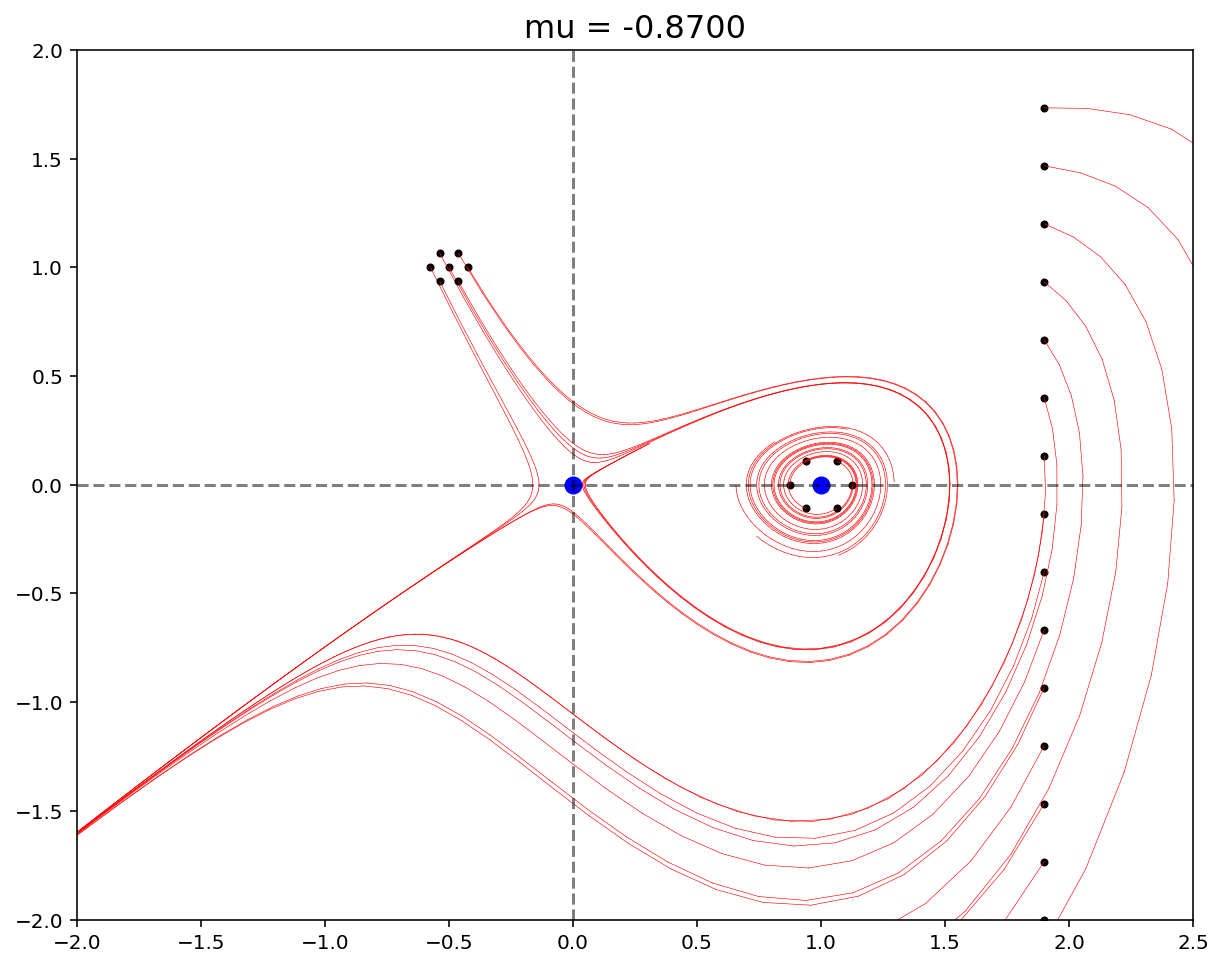

In [68]:
size = (10,8)
limits = [-2,2.5,-2,2]

points = []
points.extend(getHex(-.5,1,.15,2))
points.extend(getHex(1,0,.25,2,False))
points.extend(getLine(1.9,-2,0,4,15))

poi = [(0,0),(1,0)]
L = (150,.1,0)

par_mu = -0.87
figtitle = 'mu = %.4f'%par_mu
PlotSpace(F_homoclinic,limits,points,L,size,title=figtitle,poi=poi,yl=[0],xl=[0],
          ms=3,pms=8,trans_alpha=0.1,bounded=True)
#Flowfield(F_homoclinic,limits,getHex(0,0,3.2,15),(6,6),title=figtitle,Lstep=0.01,arrowsize=0.08)

### Josephson Junction

In [46]:
par_I = 0.3
par_alpha = 0.4
def F_josephson(x):
    xdot = np.zeros(2)
    xdot[0] = x[1]
    xdot[1] = par_I - math.sin(x[0]) - par_alpha * x[1]
    return xdot

$\ddot\Phi + \alpha\dot\Phi + sin(\Phi) = I$ can be represented as system: $\dot \Phi=y$ and $\dot y=I-sin\Phi-\alpha y$

#### Statespace and Hysteresis

Ic = 0.25464790894703254
classifier = -3.828091010097875
log(Load) : 5.26


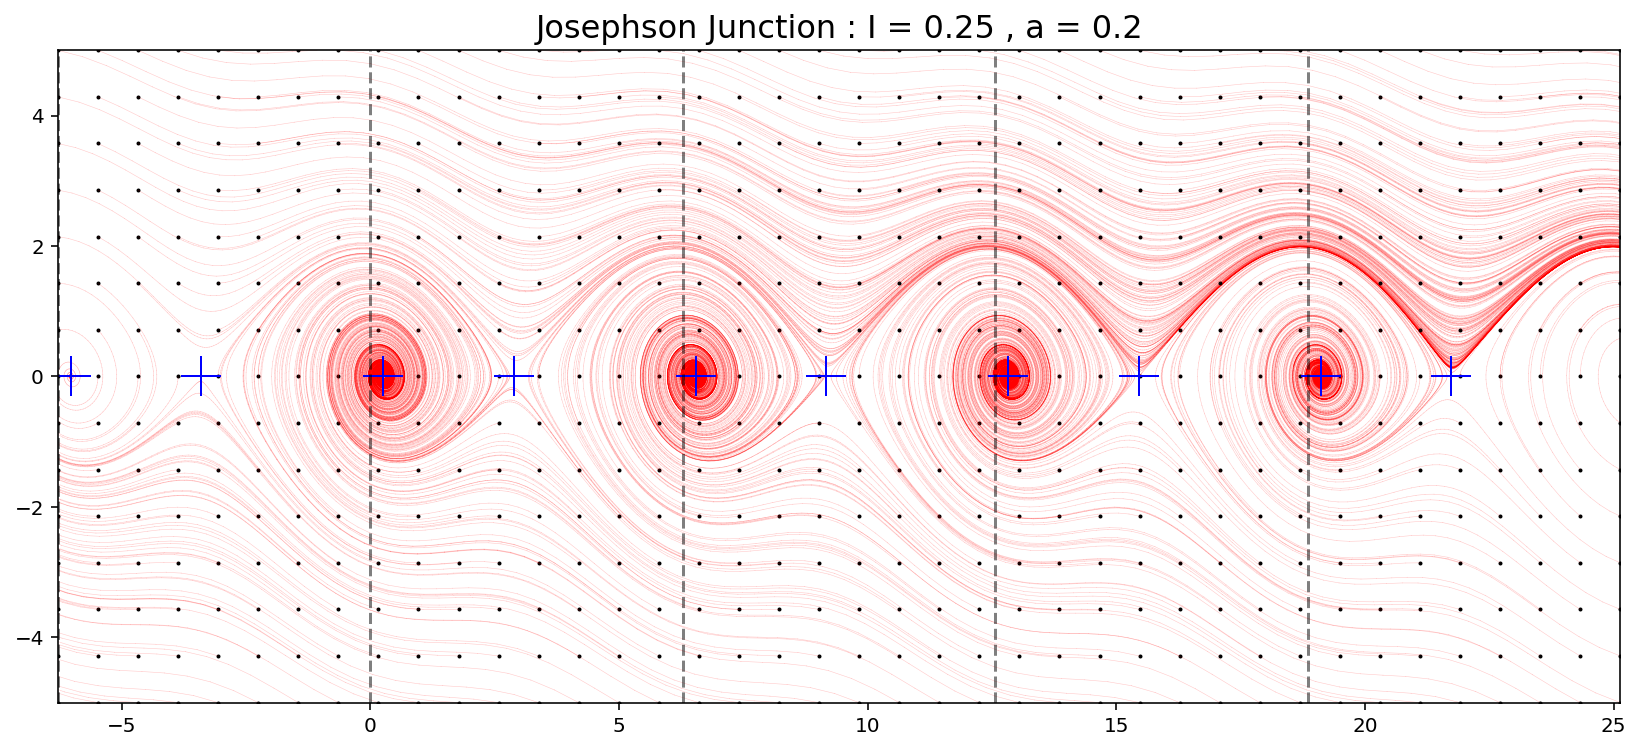

In [69]:
size = (14,6)
limits = [-2*math.pi,8*math.pi,-5,5]
points = getGrid([-2*math.pi,8*math.pi,-5,5],40,15)
L = (300,.1,250)

periods = [2*i*math.pi for i in range(-1,4)]
par_I = 0.254690
par_alpha = 0.2
print("Ic =",4*par_alpha/math.pi)
poi = []
print("classifier =",par_alpha**2-4*(1-par_I**2)**0.5)
if (par_I>=0) and (par_I<=1): 
    spx = np.arcsin(par_I)
    for i in range(-1,4):poi.extend([(spx+i*2*math.pi,0),(i*2*math.pi+(math.pi-spx),0)])

figname = 'Josephson Junction : I = %.2f , a = %.1f'%(par_I,par_alpha)
PlotSpace(F_josephson,limits,points,L,size,figname,ms=1,xl=periods,poi=poi,pms=20,marker='+')

#### Unstable Manifold of the Saddle

Ic = 0.25464790894703254
classifier = -3.8224344654634597
Max log(Load) : 4.16


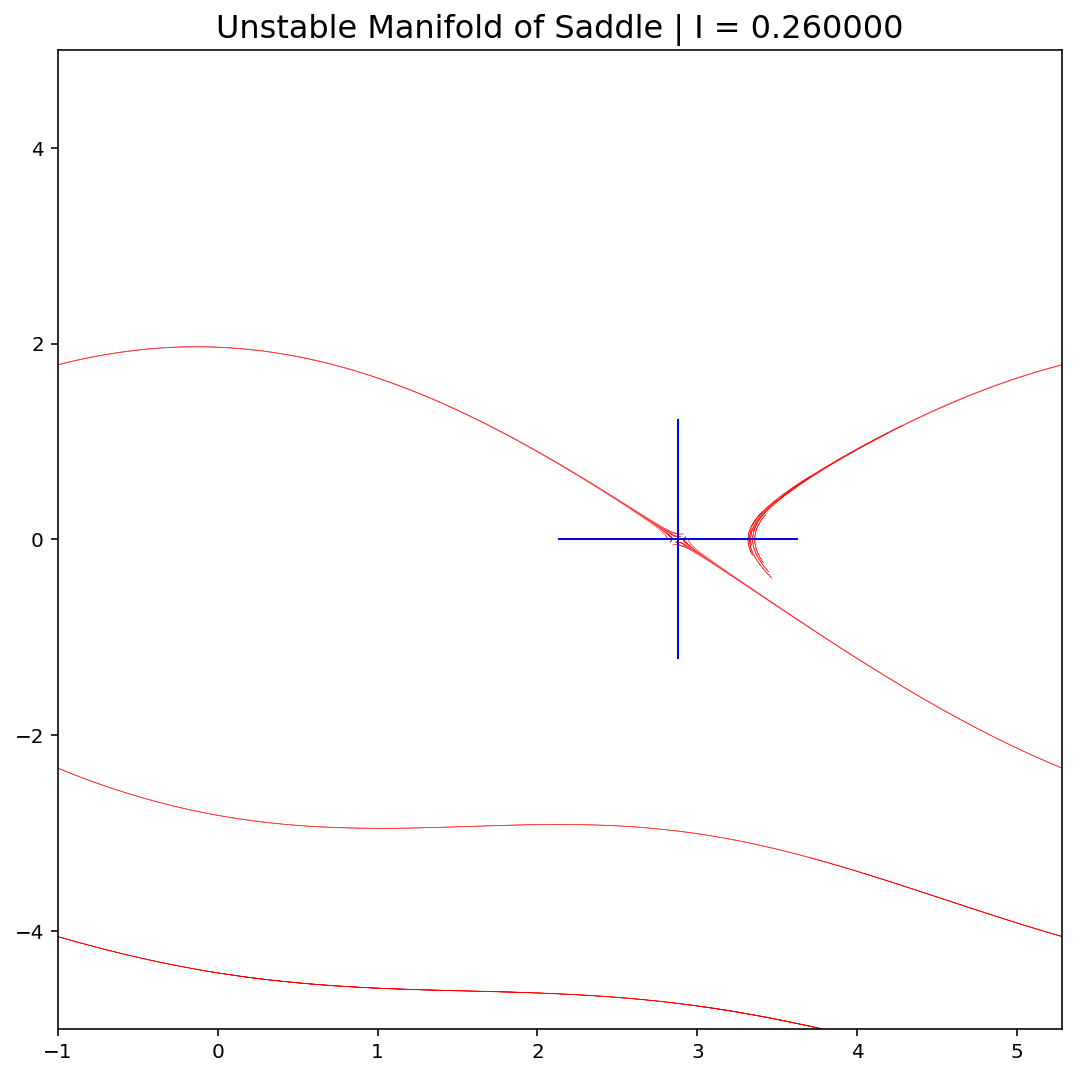

In [136]:
pi = math.pi
size = (5,5)
limits = [-1,2*pi-1,-5,5]
eps = 0.01
par_I = 0.26
par_alpha = 0.2
print("Ic =",4*par_alpha/pi)
print("classifier =",par_alpha**2-4*(1-par_I**2)**0.5)
saddlex = pi-np.arcsin(par_I)
points = getHex(saddlex,0,0.1,3,center=False)
poi = [(saddlex,0)]
L = (800,-.01,700)
name = 'Unstable Manifold | I = %f'%par_I
PlotSpace(F_josephson,limits,points,L,size,name,ms=0,poi=poi,pms=120,marker='+',xPeriodic=True)


In [138]:
pi = math.pi
size = (10,10)
limits = [-1,2*pi-1,-5,5]
eps = 0.01
par_alpha = 0.2

I_range = np.linspace(0.2,0.3,1)
points = getHex(saddlex,0,0.1,2,center=False)
L = (800,-.01,700)

frame = 0
print('[',len(I_range),end=' ] ')
for par_I in I_range:
    saddlex = pi-np.arcsin(par_I)
    poi = [(saddlex,0)]
    name = 'Unstable Manifold | I = %f'%par_I
    PlotSpace(F_josephson,limits,points,L,size,name,ms=0,poi=poi,pms=120,marker='+',xPeriodic=True,dpi=72,frame=frame)
    frame = frame + 1
    
print('\nGenerated',frame,'frames')

[ 1 ] > 0 
Generated 1 frames


#### Josephson Parameter Sweep

In [ ]:
size = (14,6)
limits = [-2*math.pi,8*math.pi,-5,5]
points = getGrid([-2*math.pi,8*math.pi,-5,5],40,15)
periods = [2*i*math.pi for i in range(-1,4)]
L = (300,.1,250)

par_alpha = 0.2
I_range = np.arange(0.2,0.3,.01)

frame = 0
print('[',len(I_range),end=' ] ')
for par_I in I_range:
    poi = []
    if (par_I>=0) and (par_I<=1): 
        spx = np.arcsin(par_I)
        for i in range(-1,4):
            poi.extend([(spx+i*2*math.pi,0),(i*2*math.pi+(math.pi-spx),0)])
            
    figname = 'Josephson Junction : I = %.3f , a = %.1f'%(par_I,par_alpha)
    PlotSpace(F_josephson,limits,points,L,size,figname,ms=1,xl=periods,poi=poi,pms=12,marker='+',frame=frame,dpi=120)
    frame = frame + 1
    
print('\nGenerated',frame,'frames')

[ 100 ] > 0 > 1 > 2 > 3 > 4 > 5 > 6 > 7 > 8 > 9 > 10 > 11 > 12 > 13 > 14 > 15 > 16 > 17 > 18 > 19 > 20 > 21 > 22 > 23 > 24 > 25 > 26 > 27 > 28 > 29 > 30 > 31 > 32 > 33 > 34 > 35 > 36 > 37 > 38 > 39 > 40 > 41 > 42 > 43 > 44 > 45 > 46 > 47 > 48 > 49 > 50 > 51 > 52 > 53 > 54 > 55 > 56 > 57 > 58 > 59 > 60 > 61 > 62 > 63 > 64 > 65 > 66 > 67 > 68 > 69 > 70 > 71 > 72 > 73 > 74 > 75 > 76 > 77 > 78 > 79 > 80 > 81 > 82 > 83 > 84 > 85 > 86 

### Video Output

In [1]:
import cv2
import os

image_folder = 'frames/'
video_name = 'JosephsonHomoclinic.avi'
videoframes = 87
fps = 5

frame = cv2.imread(os.path.join(image_folder, '0.png'))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, fps, (width,height))

for t in range(0,videoframes):
    image = str(t)+'.png'
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()
print(video_name,"with",videoframes,"frames created.")

JosephsonHomoclinic.avi with 87 frames created.
